In [1]:
import pandas as pd

# Bestandsnamen en bijbehorende variabelen
bestanden = {
    "Banen.csv": "banen_df",
    "Bevolkingsontwikkeling.csv": "bevolking_df",
    "Werkenden.csv": "werkenden_df"
}

# Opschoonfunctie
def clean_columns(df):
    df.columns = [col.replace('ï»¿', '').replace('"', '').strip() for col in df.columns]
    return df

# Inlezen en opschonen in één loop
for bestand, naam in bestanden.items():
    df = pd.read_csv(bestand, delimiter=';')
    df = clean_columns(df)
    globals()[naam] = df  # sla op als variabele met juiste naam

# Check of het gelukt is
print(banen_df.columns)
print(bevolking_df.columns)
print(werkenden_df.columns)


Index(['Unnamed: 0', 'Banen', 'Banen, seizoengecorrigeerd',
       'Banengroei, seizoengecorrigeerd'],
      dtype='object')
Index(['Perioden', 'Bevolking aan het begin van de periode (aantal)',
       'Levend geboren kinderen (aantal)', 'Overledenen (aantal)',
       'Immigratie (aantal)',
       'Emigratie inclusief administratieve c... (aantal)',
       'Overige correcties (aantal)', 'Totale bevolkingsgroei (aantal)',
       'Bevolking aan het eind van de periode (aantal)'],
      dtype='object')
Index(['Unnamed: 0', 'Werkzame beroepsbevolking'], dtype='object')


In [2]:
banen_df = banen_df.drop(columns=['Unnamed: 0'])
werkenden_df = werkenden_df.drop(columns=['Unnamed: 0'])

In [3]:
# Voeg een Jaar-kolom toe aan banen_df
banen_df["Jaar"] = range(2014, 2014 + len(banen_df))
banen_df["Banen"] = (
    banen_df["Banen"]
    .astype(str)
    .str.replace(" ", "")
    .str.replace(",", ".")
    .pipe(pd.to_numeric, errors="coerce")
)

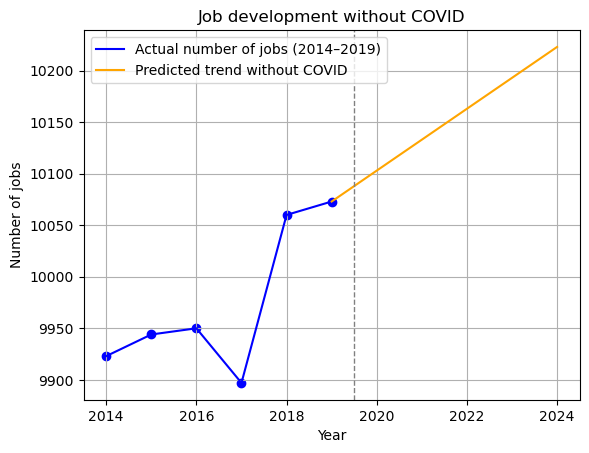

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Stap 1: Selecteer relevante kolommen
banen_df = banen_df[["Jaar", "Banen"]]

# Stap 2: Filter alleen de laatste pre-COVID jaren (bijv. 2016–2019)
recent_years = banen_df[(banen_df["Jaar"] >= 2014) & (banen_df["Jaar"] <= 2019)]

# Stap 3: Bereken gemiddelde jaarlijkse groei
recent_years = banen_df[(banen_df["Jaar"] >= 2014) & (banen_df["Jaar"] <= 2019)]
groei_per_jaar = recent_years["Banen"].diff().mean()

# Stap 4: Voorspel banen voor 2020–2024 op basis van die groei
laatste_jaar = recent_years["Jaar"].max()
laatste_banen = recent_years.loc[recent_years["Jaar"] == laatste_jaar, "Banen"].values[0]

toekomstige_jaren = range(2020, 2025)
toekomstige_banen = [laatste_banen + groei_per_jaar * (jaar - laatste_jaar) for jaar in toekomstige_jaren]

voorspelde_jaren = [laatste_jaar] + list(toekomstige_jaren)
voorspelde_banen = [laatste_banen] + toekomstige_banen

banen_extrapolatie = pd.DataFrame({
    "Jaar": voorspelde_jaren,
    "Banen_voorspeld": voorspelde_banen
})

# Stap 6: Visualiseer
# Combineer werkelijke en voorspelde data
banen_compleet = pd.concat([
    recent_years[["Jaar", "Banen"]].rename(columns={"Banen": "Banen_voorspeld"}),
    banen_extrapolatie
])

plt.plot(
    recent_years["Jaar"],
    recent_years["Banen"],
    label="Actual number of jobs (2014–2019)",
    color="blue"
)
plt.scatter(
    recent_years["Jaar"],
    recent_years["Banen"],
    color="blue"
)

# Oranje lijn: voorspelde banen (2020–2024), zonder punten
plt.plot(
    banen_extrapolatie["Jaar"],
    banen_extrapolatie["Banen_voorspeld"],
    label="Predicted trend without COVID",
    color="orange"
)

# Verticale stippellijn bij overgang
plt.axvline(x=2019.5, color="gray", linestyle="--", linewidth=1)

# Labels en layout
plt.xlabel("Year")
plt.ylabel("Number of jobs")
plt.title("Job development without COVID")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
pt_bestanden = {
    "PTbefore_TotalDistance.csv": "pt_distance_df",
    "PTbefore_TotalTravelTime.csv": "pt_time_df"
}

for bestand, naam in pt_bestanden.items():
    df = pd.read_csv(bestand, delimiter=',')
    df = clean_columns(df)
    globals()[naam] = df
    print(df.columns)

Index(['Year', 'Train_distance_million_km_per_day',
       'BusMetro_distance_million_km_per_day'],
      dtype='object')
Index(['Year', 'Train_travel_time_thousand_hours_per_day',
       'BusMetro_travel_time_thousand_hours_per_day'],
      dtype='object')


In [6]:
from sklearn.linear_model import LinearRegression

# Stap 1: definieer target kolommen per bestand
targets = {
    "pt_distance_df": [
        "Train_distance_million_km_per_day",
        "BusMetro_distance_million_km_per_day"
    ],
    "pt_time_df": [
        "Train_travel_time_thousand_hours_per_day",
        "BusMetro_travel_time_thousand_hours_per_day"
    ]
}

# Stap 2: verzamel voorspelde banen en werkelijke bevolking voor 2019–2024
banen_2020_2024 = banen_compleet.set_index("Jaar").loc[range(2020, 2025), "Banen_voorspeld"].values
bevolking_2020_2024 = bevolking_df.set_index("Perioden").loc[range(2020, 2025), "Bevolking aan het eind van de periode (aantal)"].values

X_toekomst = pd.DataFrame({
    "Banen": banen_2020_2024,
    "Bevolking": bevolking_2020_2024
})

# Stap 3: loop over alle targets en voorspel
voorspellingen = {}

for df_naam, kolommen in targets.items():
    df = globals()[df_naam]
    for kolom in kolommen:
        # Trainingsdata: 2014–2019
        train_df = df[(df["Year"] >= 2014) & (df["Year"] <= 2019)].copy()
        train_df["Banen"] = banen_df.set_index("Jaar").loc[train_df["Year"], "Banen"].values
        train_df["Bevolking"] = bevolking_df.set_index("Perioden").loc[train_df["Year"], "Bevolking aan het eind van de periode (aantal)"].values

        # Model bouwen
        X_train = train_df[["Banen", "Bevolking"]]
        y_train = train_df[kolom]
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Voorspellen
        voorspeld = model.predict(X_toekomst)
        voorspellingen[kolom] = voorspeld

        # Coëfficiënten opslaan
        coef_banen = model.coef_[0]
        coef_bevolking = model.coef_[1]
        intercept = model.intercept_

        print(f"\n📊 Regressiemodel voor: {kolom}")
        print(f"  - Intercept: {intercept:.4f}")
        print(f"  - Effect per extra baan: {coef_banen:.6f}")
        print(f"  - Effect per extra inwoner: {coef_bevolking:.6f}")


# Stap 4: zet alles in één DataFrame
pt_voorspeld_df = pd.DataFrame({
    "Jaar": range(2020, 2025)
})

for kolom, waarden in voorspellingen.items():
    pt_voorspeld_df[kolom + "_voorspeld"] = waarden

print(pt_voorspeld_df)




📊 Regressiemodel voor: Train_distance_million_km_per_day
  - Intercept: 3.2684
  - Effect per extra baan: 0.000404
  - Effect per extra inwoner: 0.000001

📊 Regressiemodel voor: BusMetro_distance_million_km_per_day
  - Intercept: 19.4870
  - Effect per extra baan: 0.000575
  - Effect per extra inwoner: -0.000001

📊 Regressiemodel voor: Train_travel_time_thousand_hours_per_day
  - Intercept: -61.9015
  - Effect per extra baan: 0.010339
  - Effect per extra inwoner: 0.000019

📊 Regressiemodel voor: BusMetro_travel_time_thousand_hours_per_day
  - Intercept: 177.5787
  - Effect per extra baan: 0.002032
  - Effect per extra inwoner: 0.000005
   Jaar  Train_distance_million_km_per_day_voorspeld  \
0  2020                                    21.318559   
1  2021                                    21.422800   
2  2022                                    21.611247   
3  2023                                    21.728589   
4  2024                                    21.821503   

   BusMetro_dista

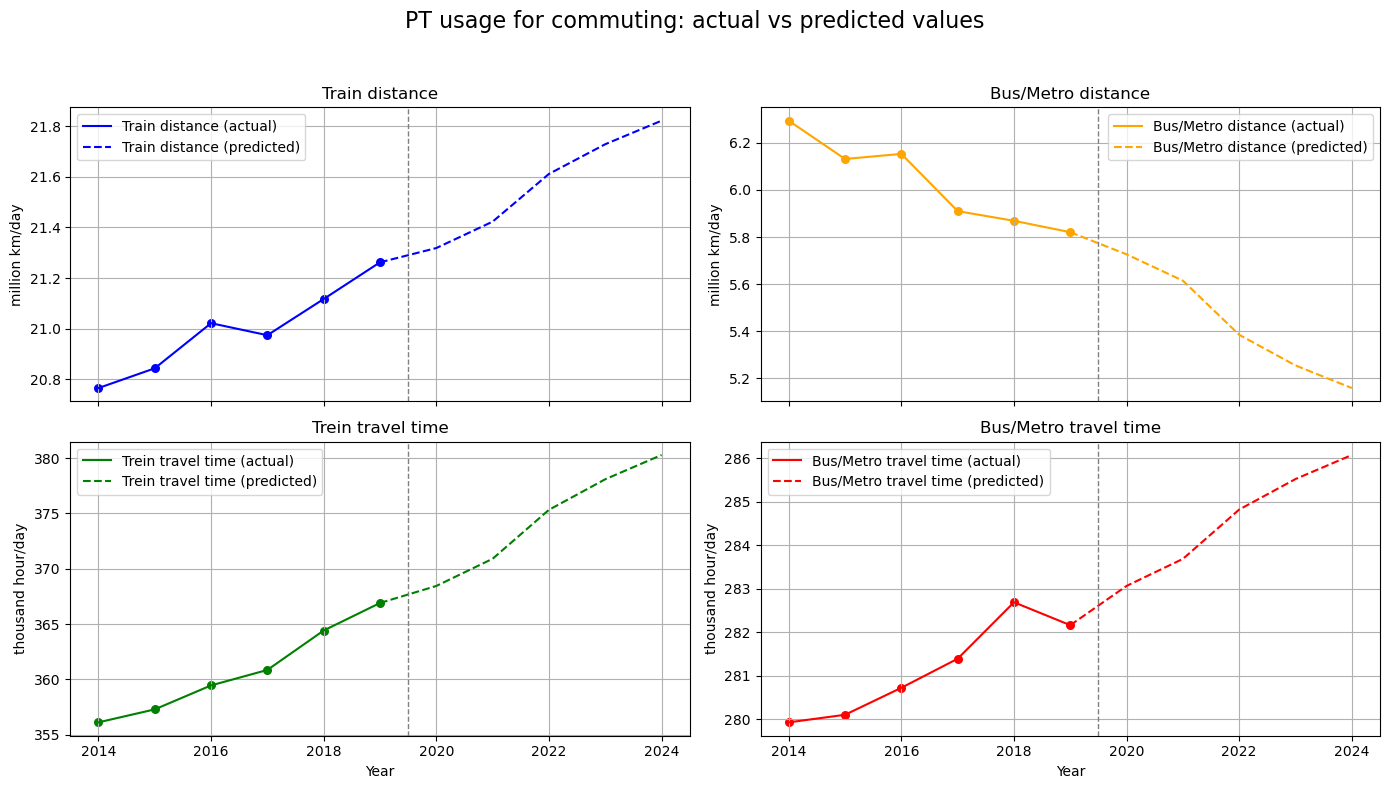

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
fig.suptitle("PT usage for commuting: actual vs predicted values", fontsize=16)

# Vervoerswijzen en instellingen
vervoerswijzen = [
    ("Train_distance_million_km_per_day", "Train distance", "million km/day", pt_distance_df),
    ("BusMetro_distance_million_km_per_day", "Bus/Metro distance", "million km/day", pt_distance_df),
    ("Train_travel_time_thousand_hours_per_day", "Trein travel time", "thousand hour/day", pt_time_df),
    ("BusMetro_travel_time_thousand_hours_per_day", "Bus/Metro travel time", "thousand hour/day", pt_time_df)
]

kleuren = ["blue", "orange", "green", "red"]

for i, (kolom, label, y_label, df) in enumerate(vervoerswijzen):
    ax = axs[i // 2, i % 2]

    # Werkelijke data
    ax.plot(df["Year"], df[kolom], label=f"{label} (actual)", color=kleuren[i])
    ax.scatter(df["Year"], df[kolom], color=kleuren[i], s=30)

    # Voorspelde data
    voorspeld = pt_voorspeld_df[kolom + "_voorspeld"]
    voorspeld_jaren = pt_voorspeld_df["Jaar"]

    # Aansluiten: voeg laatste werkelijke punt toe aan voorspelling
    laatste_jaar = df["Year"].max()
    laatste_waarde = df.loc[df["Year"] == laatste_jaar, kolom].values[0]
    voorspeld_jaren = [laatste_jaar] + list(voorspeld_jaren)
    voorspeld_waarden = [laatste_waarde] + list(voorspeld)

    ax.plot(voorspeld_jaren, voorspeld_waarden, label=f"{label} (predicted)", color=kleuren[i], linestyle="--")

    # Layout
    ax.axvline(x=2019.5, color="gray", linestyle="--", linewidth=1)
    ax.set_title(label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



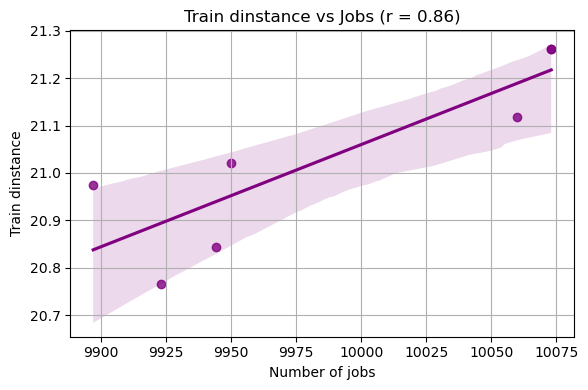

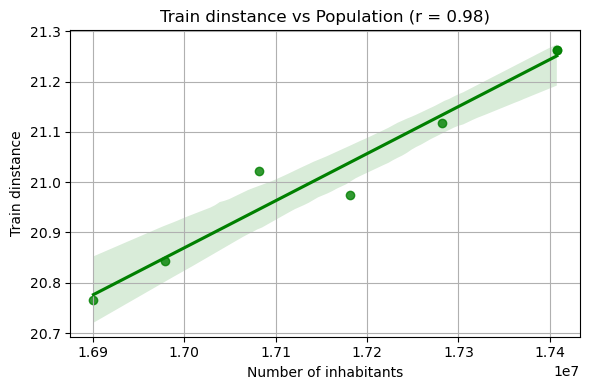

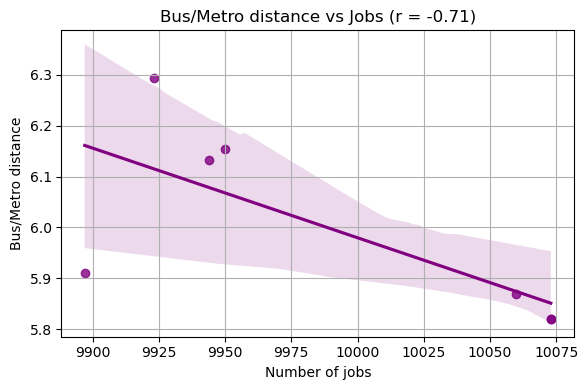

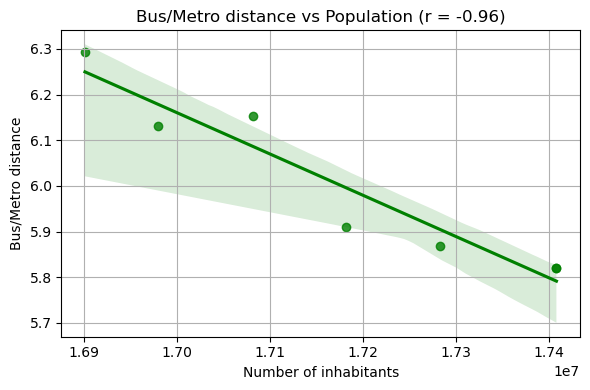

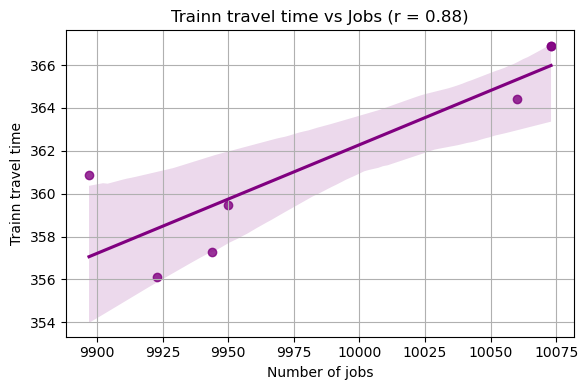

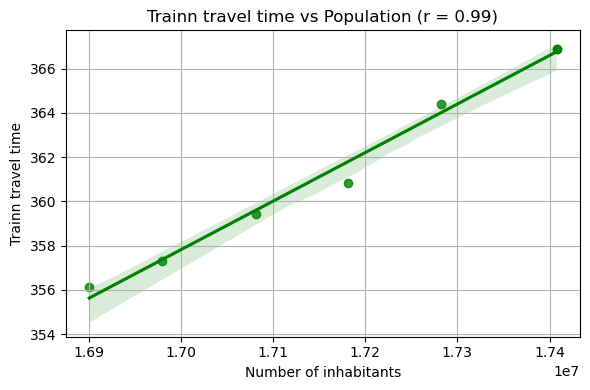

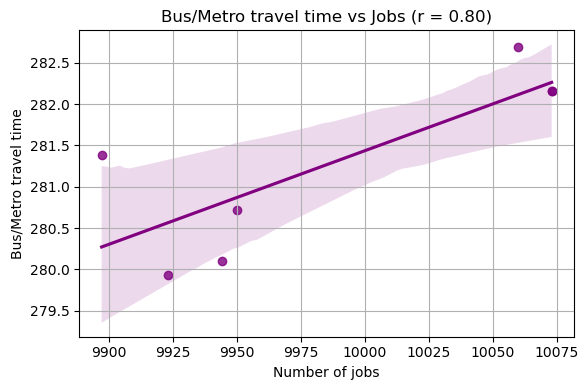

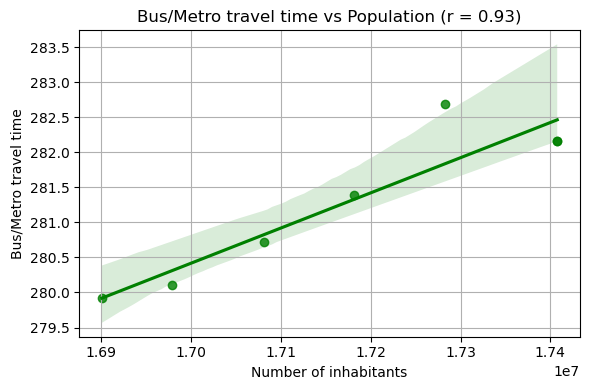

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

# Jaren voor analyse
jaren = list(range(2014, 2020))  # 2014 t/m 2019

# Data filteren op jaren
pt_distance_filtered = pt_distance_df[pt_distance_df["Year"].isin(jaren)]
pt_time_filtered = pt_time_df[pt_time_df["Year"].isin(jaren)]
banen_filtered = banen_compleet[banen_compleet["Jaar"].isin(jaren)]
bevolking_filtered = bevolking_df[bevolking_df["Perioden"].isin(jaren)]

# Mapping: (PT-kolom, label, dataframe)
plots = [
    ("Train_distance_million_km_per_day", "Train dinstance", pt_distance_filtered),
    ("BusMetro_distance_million_km_per_day", "Bus/Metro distance", pt_distance_filtered),
    ("Train_travel_time_thousand_hours_per_day", "Trainn travel time", pt_time_filtered),
    ("BusMetro_travel_time_thousand_hours_per_day", "Bus/Metro travel time", pt_time_filtered)
]

for kolom, label, df in plots:
    # Bouw een gezamenlijke DataFrame per jaar
    df_merged = pd.DataFrame({
        "Jaar": df["Year"].values,
        "PT": df[kolom].values
    })

    # Voeg werkgelegenheid toe
    df_merged = df_merged.merge(
        banen_filtered[["Jaar", "Banen_voorspeld"]],
        on="Jaar", how="inner"
    )

    # Voeg bevolking toe
    df_merged = df_merged.merge(
        bevolking_filtered[["Perioden", "Bevolking aan het eind van de periode (aantal)"]],
        left_on="Jaar", right_on="Perioden",
        how="inner"
    )

    # Plot: PT vs Werkgelegenheid
    r_banen, _ = pearsonr(df_merged["Banen_voorspeld"], df_merged["PT"])
    plt.figure(figsize=(6, 4))
    sns.regplot(x="Banen_voorspeld", y="PT", data=df_merged, color="purple")
    plt.title(f"{label} vs Jobs (r = {r_banen:.2f})")
    plt.xlabel("Number of jobs")
    plt.ylabel(label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: PT vs Bevolking
    r_bevolking, _ = pearsonr(df_merged["Bevolking aan het eind van de periode (aantal)"], df_merged["PT"])
    plt.figure(figsize=(6, 4))
    sns.regplot(x="Bevolking aan het eind van de periode (aantal)", y="PT", data=df_merged, color="green")
    plt.title(f"{label} vs Population (r = {r_bevolking:.2f})")
    plt.xlabel("Number of inhabitants")
    plt.ylabel(label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
